In [42]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.engine.base import Engine
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.xgboost
import random
import xgboost as xgb

# Import and prepare data

In [2]:
def get_db_engine(
    username: str,
    password: str,
    protocol: str = "postgresql",
    server: str = "localhost",
    port: int = 5432,
    dbname: str = "ufc",
) -> Engine:

    engine = create_engine(
        f"{protocol}://" f"{username}:" f"{password}@" f"{server}:" f"{port}/" f"{dbname}",
        isolation_level="AUTOCOMMIT",
    )
    return engine

In [3]:
def get_data(engine: Engine) -> pd.DataFrame:
    df = pd.read_sql("SELECT * FROM ufc.model_input", engine)
    return df

def split_data(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    X = df.drop(columns=["fighter1", "fighter2", "win"])
    y = df["win"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [4]:
df = get_data(get_db_engine("postgres", "postgres"))
X_train, X_test, y_train, y_test = split_data(df)

## Setup local MLflow instance

In [5]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_name = 'xgboost'

# Create experiment if not exists
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# set experiment
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/591571160433496017', creation_time=1698089517955, experiment_id='591571160433496017', last_update_time=1698089517955, lifecycle_stage='active', name='xgboost', tags={}>

## First experiment

In [22]:
# Start a new MLflow run
with mlflow.start_run(run_name="xgboost_iter_1") as run:

    # Log parameters
    params = {
        "max_depth": 6,
        "eta": 0.3,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "num_round": 100
    }
    mlflow.log_params(params)

    # Load data
    train_data = xgb.DMatrix(X_train, label=y_train)
    test_data = xgb.DMatrix(X_test, label=y_test)

    # Train model
    model = xgb.train(params, train_data)

    # Evaluate model
    preds = model.predict(test_data)
    auc_score = roc_auc_score(y_test, preds)

    # Log metrics
    mlflow.log_metric("auc", auc_score)

    # Log model
    mlflow.xgboost.log_model(model, "model")

/root/.cache/pypoetry/virtualenvs/ufc-fight-predictor-MyfLQ-ai-py3.10/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:54:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/root/.cache/pypoetry/virtualenvs/ufc-fight-predictor-MyfLQ-ai-py3.10/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:54:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/root/.cache/pypoetry/virtualenvs/ufc-fight-predictor-MyfLQ-ai-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils di

## Second experimentation with random hyper parameter search

In [27]:
def xgboost_random_search_with_mlflow(param_distributions, n_iter=10, experiment_name="XGBoost Hyperparam Tuning", num_folds=5):
    """
    Perform random search over XGBoost parameters with k-fold cross-validation and log results to MLflow.
    
    Parameters:
    - param_distributions: Dictionary where keys are XGBoost parameter names and values are lists or ranges of values to sample from.
    - n_iter: Number of random combinations to try.
    - experiment_name: Name of the MLflow experiment.
    - num_folds: Number of folds for cross-validation.
    """

    # Set the MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Perform random search
    for i in range(n_iter):
        params = {k: random.choice(v) for k, v in param_distributions.items()}
        
        # Initialize lists to store fold metrics
        accuracy_scores = []
        f1_scores = []
        roc_auc_scores = []
        train_accuracy_scores = []  # List to store training set accuracy
        
        # Perform k-fold cross-validation
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X_train):
            X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
            
            # Train XGBoost with current hyperparameters
            model = xgb.XGBClassifier(**params)
            model.fit(X_fold_train, y_fold_train)
            
            # Predict and evaluate on the validation fold
            y_fold_pred = model.predict(X_fold_val)
            
            accuracy_scores.append(accuracy_score(y_fold_val, y_fold_pred))
            f1_scores.append(f1_score(y_fold_val, y_fold_pred))
            roc_auc_scores.append(roc_auc_score(y_fold_val, model.predict_proba(X_fold_val)[:, 1]))
            
            # Calculate and log training set accuracy for each fold
            train_accuracy = accuracy_score(y_fold_train, model.predict(X_fold_train))
            train_accuracy_scores.append(train_accuracy)

        # Calculate mean metrics across folds
        mean_accuracy = np.mean(accuracy_scores)
        mean_f1 = np.mean(f1_scores)
        mean_roc_auc = np.mean(roc_auc_scores)
        
        # Calculate mean training set accuracy across folds
        mean_train_accuracy = np.mean(train_accuracy_scores)
        
        # Log the results to MLflow
        with mlflow.start_run():
            mlflow.log_params(params)
            mlflow.log_metric("accuracy", mean_accuracy)
            mlflow.log_metric("f1", mean_f1)
            mlflow.log_metric("roc_auc", mean_roc_auc)
            mlflow.log_metric("train_accuracy", mean_train_accuracy)  # Log training set accuracy
            mlflow.xgboost.log_model(model, "model")
            
    print(f"Random search completed with {num_folds}-fold cross-validation. You can view the experiments and results in the MLflow UI.")

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'n_estimators': [10, 50, 100, 150, 200, 250],
    'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4], 
    'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4]
}

# This will randomly sample from the provided distributions for 10 iterations with 5-fold cross-validation.
xgboost_random_search_with_mlflow(param_distributions, n_iter=10, num_folds=5)

2023/10/23 22:18:42 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Hyperparam Tuning' does not exist. Creating a new experiment.
/root/.cache/pypoetry/virtualenvs/ufc-fight-predictor-MyfLQ-ai-py3.10/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:21:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/root/.cache/pypoetry/virtualenvs/ufc-fight-predictor-MyfLQ-ai-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that s

Random search completed with 5-fold cross-validation. You can view the experiments and results in the MLflow UI.


/root/.cache/pypoetry/virtualenvs/ufc-fight-predictor-MyfLQ-ai-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/ufc-fight-predictor-MyfLQ-ai-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [ ]:
# Same method but with standardization of inputs
def xgboost_random_search_with_mlflow_with_standardization(param_distributions, n_iter=10, experiment_name="XGBoost Hyperparam Tuning", num_folds=5):
    """
    Perform random search over XGBoost parameters with k-fold cross-validation, standardize inputs, and log results to MLflow.
    
    Parameters:
    - param_distributions: Dictionary where keys are XGBoost parameter names and values are lists or ranges of values to sample from.
    - n_iter: Number of random combinations to try.
    - experiment_name: Name of the MLflow experiment.
    - num_folds: Number of folds for cross-validation.
    """

    # Set the MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Perform random search
    for i in range(n_iter):
        params = {k: random.choice(v) for k, v in param_distributions.items()}
        
        # Initialize lists to store fold metrics
        accuracy_scores = []
        f1_scores = []
        roc_auc_scores = []
        train_accuracy_scores = []  # List to store training set accuracy
        
        # Perform k-fold cross-validation
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X_train):
            X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
            
            # Standardize inputs (fit on training, transform on both)
            scaler = StandardScaler()
            X_fold_train_std = scaler.fit_transform(X_fold_train)
            X_fold_val_std = scaler.transform(X_fold_val)
            
            # Train XGBoost with current hyperparameters
            model = xgb.XGBClassifier(**params)
            model.fit(X_fold_train_std, y_fold_train)
            
            # Predict and evaluate on the validation fold
            y_fold_pred = model.predict(X_fold_val_std)
            
            accuracy_scores.append(accuracy_score(y_fold_val, y_fold_pred))
            f1_scores.append(f1_score(y_fold_val, y_fold_pred))
            roc_auc_scores.append(roc_auc_score(y_fold_val, model.predict_proba(X_fold_val_std)[:, 1]))
            
            # Calculate and log training set accuracy for each fold
            train_accuracy = accuracy_score(y_fold_train, model.predict(X_fold_train_std))
            train_accuracy_scores.append(train_accuracy)

        # Calculate mean metrics across folds
        mean_accuracy = np.mean(accuracy_scores)
        mean_f1 = np.mean(f1_scores)
        mean_roc_auc = np.mean(roc_auc_scores)
        
        # Calculate mean training set accuracy across folds
        mean_train_accuracy = np.mean(train_accuracy_scores)
        
        # Log the results to MLflow
        with mlflow.start_run():
            mlflow.log_params(params)
            mlflow.log_metric("accuracy", mean_accuracy)
            mlflow.log_metric("f1", mean_f1)
            mlflow.log_metric("roc_auc", mean_roc_auc)
            mlflow.log_metric("train_accuracy", mean_train_accuracy)  # Log training set accuracy
            mlflow.xgboost.log_model(model, "model")
            
    print(f"Random search completed with {num_folds}-fold cross-validation and standardization. You can view the experiments and results in the MLflow UI.")

xgboost_random_search_with_mlflow_with_standardization(param_distributions, n_iter=10, num_folds=5, experiment_name="XGBoost Hyperparam Tuning with Standardization")

# Model evaluation and interpretation

In [37]:
def summarize_mlflow_runs(experiment_name):
    """
    Summarize MLflow runs for a given experiment.

    Parameters:
    - experiment_name: Name of the MLflow experiment.

    Returns:
    - summary_df: DataFrame summarizing the runs.
    """

    # Set the MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Fetch all runs from the MLflow experiment
    runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], filter_string="tags.mlflow.runName != 'None'")

    # Define the metrics to include in the summary table
    metrics_to_include = ["train_accuracy", "accuracy", "f1", "roc_auc"]

    # Create an empty summary DataFrame
    summary_df = pd.DataFrame(columns=["Model"] + metrics_to_include + ["n_estimators", "max_depth", "learning_rate", "reg_alpha", "reg_lambda"])

    # Iterate through the runs and extract relevant metrics and parameters
    for _, run in runs.iterrows():
        model_name = run["tags.mlflow.runName"]
        metrics = [run[f"metrics.{metric}"] for metric in metrics_to_include]

        # Extract specific parameters from the run's tags
        n_estimators = run["params.n_estimators"]
        max_depth = run["params.max_depth"]
        learning_rate = run["params.learning_rate"]
        reg_alpha = run["params.reg_alpha"]
        reg_lambda = run["params.reg_lambda"]

        # Append metrics and parameters to the summary DataFrame
        summary_df.loc[len(summary_df)] = [model_name] + metrics + [n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda]

    # Sort the summary DataFrame by the desired metric (e.g., ROC AUC)
    sorted_summary_df = summary_df.sort_values(by="roc_auc", ascending=False)

    return sorted_summary_df

# Example usage:
experiment_name = "XGBoost Hyperparam Tuning"
experiment_name_standardize = "XGBoost Hyperparam Tuning with Standardization"
summary_df = summarize_mlflow_runs(experiment_name)
summary_df_standardize = summarize_mlflow_runs(experiment_name_standardize)
summary_df['standardize'] = False
summary_df_standardize['standardize'] = True
total_summary = pd.concat([summary_df, summary_df_standardize])
total_summary.sort_values(by="roc_auc", ascending=False, inplace=True)
print("Performance Summary Table (Sorted by ROC AUC)")
print(total_summary.head())



Performance Summary Table (Sorted by ROC AUC)
                  Model  train_accuracy  accuracy        f1   roc_auc   
4    unleashed-sloth-12        0.814883  0.745151  0.743755  0.815232  \
1        suave-hawk-979        0.839409  0.744036  0.742278  0.815125   
4  adventurous-colt-176        0.837960  0.747380  0.745722  0.814154   
5      abrasive-koi-445        0.827815  0.740691  0.741487  0.812947   
8       sneaky-lynx-881        0.886009  0.741583  0.739387  0.812004   

  n_estimators max_depth learning_rate reg_alpha reg_lambda  standardize  
4          150         3           0.1       0.0        0.1        False  
1           50         5           0.1       0.3        0.2         True  
4           50         5           0.1       0.2        0.4         True  
5          100         3           0.2       0.4        0.1        False  
8          200         4           0.1       0.0        0.0         True  


Roc_auc of the best model is 0.815, not too bad actually! We do have to keep in mind that for this run we use perfect information. Meaning that for this training run, we use performance statistics at the last point in the career of the fighters, so we already know how good or bad they are based on their career wins and losses. 
## Roc auc curve

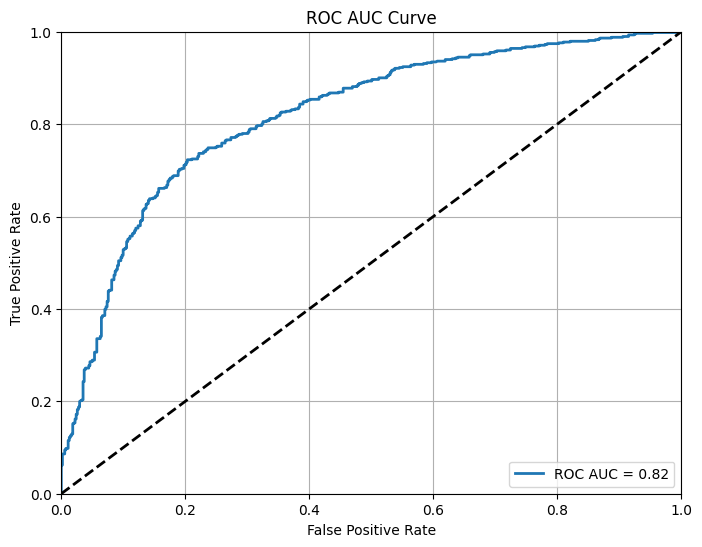

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have already sorted_summary_df with the best-performing model at the top
best_model_name = total_summary.iloc[0]["Model"]

runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], filter_string="tags.mlflow.runName != 'None'")

# Find the corresponding MLflow run for the best model
best_model_run = runs[runs["tags.mlflow.runName"] == best_model_name]

# Load the best model using MLflow
best_model = mlflow.xgboost.load_model(best_model_run.iloc[0]["artifact_uri"] + "/model")

# Make predictions on your test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The curve starts from the point (0,0) which corresponds to a threshold that classifies all instances as negative. Resulting in zero true positive, and zero false positive rate. The curve moves towards (1,1) as the threshold decreases and more predictions will be positive. Indicating a higher true positive rate and also a higher false positive rate. The diagonal line represents a completely random classifier with no predictive power. We can see that the curve looks quite good, as reflected by the statistic!
## Feature importance

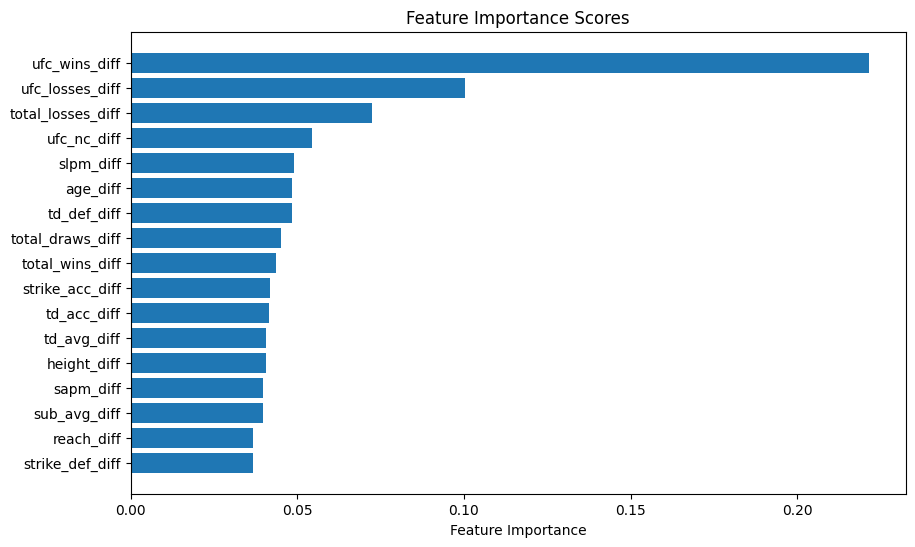

In [39]:
import mlflow
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Load the best model from your MLflow experiments
experiment_name = "XGBoost Hyperparam Tuning"  # Update with your experiment name
best_run = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], filter_string="tags.mlflow.runName != 'None'", order_by=["metrics.roc_auc desc"]).iloc[0]
best_model_uri = f"runs:/{best_run.run_id}/model"

# Load the best model using mlflow.xgboost
loaded_model = mlflow.xgboost.load_model(best_model_uri)

# Train the best model on your entire dataset (train + validation)
loaded_model.fit(X_train, y_train)  # Replace X_train and y_train with your data

# Extract feature importance scores
feature_importance = loaded_model.feature_importances_

# Get the names of the features (assuming X_train is a DataFrame)
feature_names = X_train.columns

# Create a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], align='center')
plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Scores')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

# Optionally, save the feature importance DataFrame to a CSV file
feature_importance_df.to_csv('feature_importance.csv', index=False)


## SHAP analysis
Shap values can help us get a better understanding of feature importance by actually showing the effects of the features on an individual sample basis.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[13:20:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 94%|=================== | 4208/4485 [00:14<00:00]       

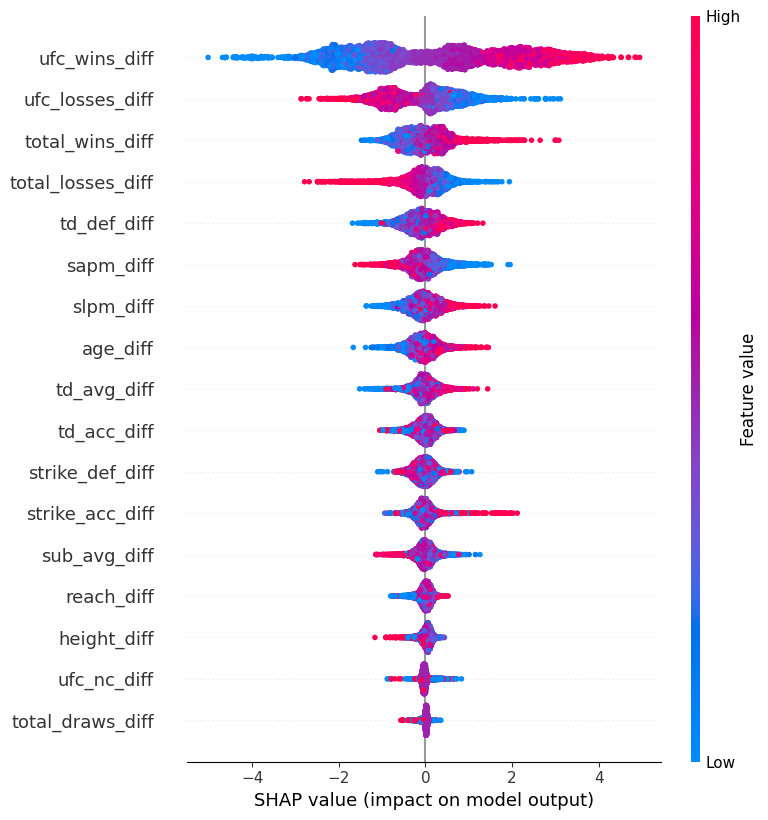

In [40]:
import shap
# Perform SHAP analysis
explainer = shap.Explainer(loaded_model, X_train)  # Create a SHAP explainer
shap_values = explainer(X_train)  # Calculate SHAP values

# Plot a summary plot of SHAP values
shap.summary_plot(shap_values, X_train)

plt.show()

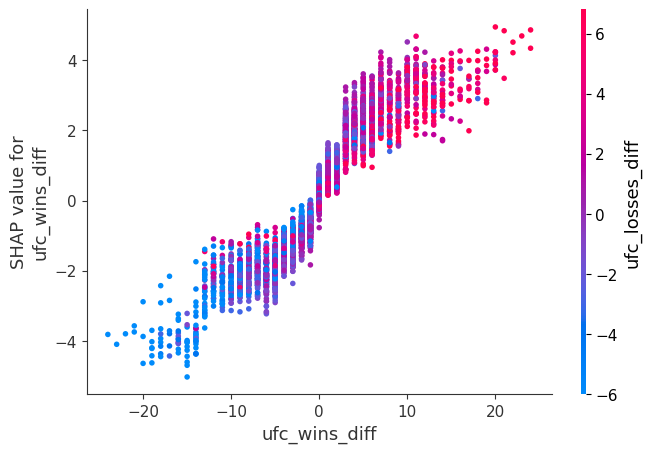

In [41]:
# Plot the interaction plot for the shap values for ufc wins and ufc losses
shap.dependence_plot("ufc_wins_diff", shap_values.values, X_train, interaction_index="ufc_losses_diff")